In [ ]:
# original pennylane demo code - no kmeans, pytorch, bayesian, etc

In [1]:
%matplotlib inline

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

Quantum and classical nodes
===========================

We then create a quantum device that will run our circuits.


In [3]:
dev = qml.device("default.qubit")

In [4]:
# angle encoding - maps data to rotation angles for quantum gates.
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Let's test if this routine actually works.


In [5]:
x = np.array([0.4746, 0.6610, 0.1, 0.1], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.4746 0.661  0.1    0.1   ]
angles          :  [ 0.344148 -0.785398  0.785398 -0.94809   0.94809 ]
amplitude vector:  [0.574623 0.800307 0.121075 0.121075]


The method computed the correct angles to prepare the desired state!

> ::: {.note}
> ::: {.title}
> Note
> :::
>
> The `default.qubit` simulator provides a shortcut to
> `state_preparation` with the command `qml.StatePrep(x, wires=[0, 1])`.
> On state simulators, this just replaces the quantum state with our
> (normalized) input. On hardware, the operation implements more
> sophisticated versions of the routine used above.
> :::


Since we are working with only 2 qubits now, we need to update the
`layer` function. In addition, we redefine the `cost` function to pass
the full batch of data to the state preparation of the circuit
simultaneously, a technique similar to NumPy broadcasting.


In [6]:
# CIRCUIT 
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])
    
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [7]:
# COST + ACCURACY FUNCTIONS
def square_loss(labels, predictions): # Calculates error between predicted and actual labels, penalizes larger errors quadratically
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions): # Computes the accuracy of predictions compared to true labels
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

In [34]:
# LOAD DATA 
# X train
X = np.loadtxt("trainX.txt")

# padding = np.ones((len(X), 2)) * 0.1
# X_pad = np.c_[X, padding]
# normalization = np.sqrt(np.sum(X_pad**2, -1))
# X_norm = (X_pad.T / normalization).T
# feats_train = np.array([get_angles(x) for x in X_norm], requires_grad=False)

# Y train
Y = np.loadtxt("trainY.txt")
Y_train = np.where(Y == 0, -1.0, 1.0)

print(len(Y))
# X = X[:600]
# Y = Y[:600]

# X test
# X = np.loadtxt("testX.txt")
# padding = np.ones((len(X), 2)) * 0.1
# X_pad = np.c_[X, padding]
# normalization = np.sqrt(np.sum(X_pad**2, -1))
# X_norm = (X_pad.T / normalization).T
# feats_val = np.array([get_angles(x) for x in X_norm], requires_grad=False)

# # Y test
# Y = np.loadtxt("testY.txt")
# Y_val = np.where(Y == 0, -1.0, 1.0)

# feats_train = feats_train[:400]
# y_train = Y_train[:400]
# feats_test = feats_val[:400]
# y_test = Y_val[:400]

1600


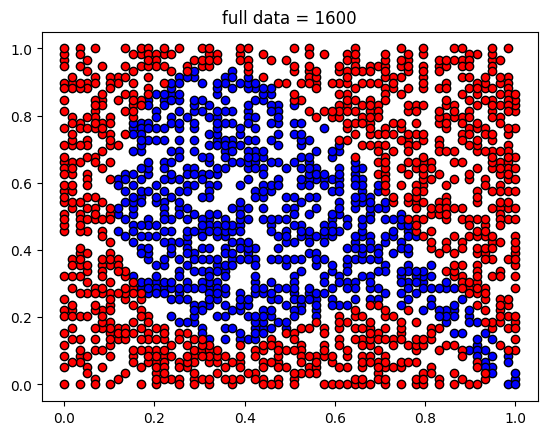

In [36]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == 0], X[:, 1][Y == 0], c="r", marker="o", ec="k")
plt.title("full data = 1600")
plt.show()

# plt.figure()
# dim1 = 0
# dim2 = 2
# plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
# plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
# plt.title(f"Feature vectors (dims {dim1} and {dim2})")
# plt.show()

This time we want to generalize from the data samples. This means that
we want to train our model on one set of data and test its performance
on a second set of data that has not been used in training. To monitor
the generalization performance, the data is split into training and
validation set.


Optimization
============

First we initialize the variables.


In [56]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

Again we minimize the cost, using the imported optimizer.


In [57]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 128

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.2138008 | Acc train: 0.4937500 | Acc validation: 0.0137500
Iter:     4 | Cost: 1.1405395 | Acc train: 0.4925000 | Acc validation: 0.0262500
Iter:     6 | Cost: 1.0977351 | Acc train: 0.5487500 | Acc validation: 0.0468750
Iter:     8 | Cost: 1.1119928 | Acc train: 0.5556250 | Acc validation: 0.0743750
Iter:    10 | Cost: 1.1090749 | Acc train: 0.5550000 | Acc validation: 0.0725000
Iter:    12 | Cost: 1.0967540 | Acc train: 0.5637500 | Acc validation: 0.0656250
Iter:    14 | Cost: 1.1034725 | Acc train: 0.5231250 | Acc validation: 0.0337500
Iter:    16 | Cost: 1.1679214 | Acc train: 0.4762500 | Acc validation: 0.0193750
Iter:    18 | Cost: 1.1837201 | Acc train: 0.4887500 | Acc validation: 0.0162500
Iter:    20 | Cost: 1.1583669 | Acc train: 0.4787500 | Acc validation: 0.0212500
Iter:    22 | Cost: 1.1071531 | Acc train: 0.5100000 | Acc validation: 0.0300000
Iter:    24 | Cost: 1.0941616 | Acc train: 0.5318750 | Acc validation: 0.0368750
Iter:    26 | Cost: 1.090866

We can plot the continuous output of the variational classifier for the
first two dimensions of the Iris data set.


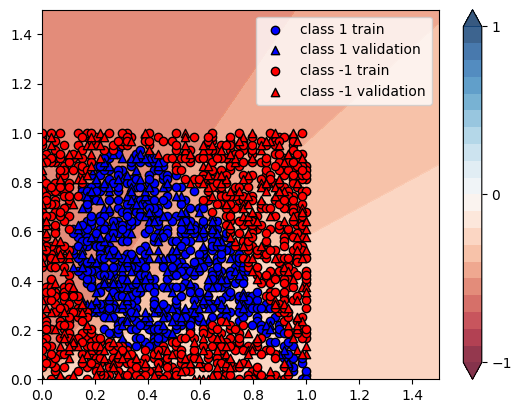

In [44]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

We find that the variational classifier learnt a separating line between
the datapoints of the two different classes, which allows it to classify
even the unseen validation data with perfect accuracy.